# Introduction

The goal of this project is to analyze the LIGO Handford and LIGO Livingston data for the GW150914 gravitational wave signal at a rudimentary level. In other words, we want to determine the masses of the black holes given the data. The process for doing this is described in the data guide [paper](https://iopscience.iop.org/article/10.1088/1361-6382/ab685e). To do this, we have to build a model of the gravitational waves we expect to see. Below I use a code written by Travis Robson that describes a PhenomA waveform taken from [here](https://github.com/eXtremeGravityInstitute/LISA_Sensitivity/blob/master/PhenomA.py). The code gives us the frequency domain amplitude, $A(f)$, and phase, $\Psi(f)$, for the frequency domain wavefrom described by $h(f) = A(f) e^{i \Psi(f)}$. Unfortunately, there are necessary corrections that need to be made from the original code.

In [1]:
import numpy as np

TSUN = 4.9169e-6
clight = 2.998e8

# PhenomA, frequency coefficients
a = np.array([2.9740e-1, 5.9411e-1, 5.0801e-1, 8.4845e-1])
b = np.array([4.4810e-2, 8.9794e-2, 7.7515e-2, 1.2848e-1])
c = np.array([9.5560e-2, 1.9111e-1, 2.2369e-2, 2.7299e-1])

# PhenomA, phase coefficients
x = np.array([1.7516e-1, 0., -5.1571e1, 6.5866e2, -3.9031e3, 0., -2.4874e4, 2.5196e4])
y = np.array([7.9483e-2, 0., -1.7595e1, 1.7803e2, -7.7493e2, 0., -1.4892e3, 3.3970e2])
z = np.array([-7.2390e-2, 0., 1.3253e1, -1.5972e2, 8.8195e2, 0., 4.4588e3, -3.9573e3])


def Lorentzian(f, f_ring, sigma):
    """ """ 
    return sigma/(2*np.pi)/( (f-f_ring)**2 + 0.25*sigma**2 )
    
    
def get_freq(M, eta, name):
    """ """
    if (name == "merg"):
       idx = 0
    elif (name == "ring"):
        idx = 1
    elif (name == "sigma"):
        idx = 2
    elif (name == "cut"):
        idx = 3
        
    result = a[idx]*eta**2 + b[idx]*eta + c[idx]
    
    return result/(np.pi*M)
    
def Aeff(f, M, eta, Dl):
    """ """
    
    # generate phenomA frequency parameters
    f_merg = get_freq(M, eta, "merg")
    f_ring = get_freq(M, eta, "ring")
    sigma  = get_freq(M, eta, "sigma")
    f_cut  = get_freq(M, eta, "cut")
    
    # break up frequency array into pieces
    mask1 = (f<f_merg)
    mask2 = (f>=f_merg) & (f<f_ring)
    mask3 = (f>=f_ring) & (f<f_cut)
    
    C = clight*M**(5./6)/Dl/np.pi**(2./3.)/f_merg**(7./6)*np.sqrt(5.*eta/24) # Corrected the units
    w = 0.5*np.pi*sigma*(f_ring/f_merg)**(-2./3)
    
    A = np.zeros(len(f))
    
    A[mask1] = C*(f[mask1]/f_merg)**(-7./6)
    A[mask2] = C*(f[mask2]/f_merg)**(-2./3)
    A[mask3] = C*w*Lorentzian(f[mask3], f_ring, sigma)
    
    return A
    
def Psieff(f, M, eta, t0, phi0):
    """ """
    
    result = 0.0
    
    for i in range(8): # Corrected to go from 0 to 7
        result += (x[i]*eta**2 + y[i]*eta + z[i])*(np.pi*M*f)**((i-5.)/3.)
        
    return 2*np.pi*f*t0 + phi0 + result/eta
    
def dPsieff_df(f, M, eta, t0):
    """ """
    
    result = 0.0
    
    for i in range(8): # Corrected to go from 0 to 7
        result += ((i-5.)/3.)*(x[i]*eta**2 + y[i]*eta + z[i])*(np.pi*M)**((i-5.)/3.)*f**((i-5.)/3. - 1)
    
    return 2*np.pi*t0 + result/eta

# Calculating the SNR times series

The first step in our analysis is to determine the signal-to-noise (SNR) times series. The SNR times series is given by $\rho(t, M_1, M_2) = \lvert z(t, M_1, M_2) \lvert$, where $z(t, M_1, M_2)$ is,
\begin{equation}
z(t, M_1, M_2) = 4 \int^{\infty}_{0} \frac{\widetilde{d}(f) \widetilde{p}^{*}(f, M_1, M_2)}{S_{n}(f)} e^{2 \pi i f t} df
\end{equation}
and $\widetilde{d}(f)$ is the Fourier transform of the data, $S_{n}(f)$ is the noise power spectral density, and $\widetilde{p} (f, M_1, M_2)$ is our normalized waveform template. We need to get the data for the two detectors and we need to calculate $S_{n}(f)$. 

## Getting the waveform data
Let's start with getting the data. The data we're looking for are the are given on the [LIGO website](https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/). We want the downsized 4096 Hz data for each detector, but we only want to use the 4 seconds of the data that's around merger in our analysis. Below, I download the data from the website and extract the 4 seconds of data we want.

In [2]:
import urllib.request
from urllib.request import urlopen
import json
import pathlib
import gzip
import shutil
import os
import re

CURRENT_PATH = pathlib.Path().absolute().__str__()

# Using json file on the website to get URLs for the data and the merger time so I can get the right 4 seconds of data
urljson = 'https://www.gw-openscience.org/eventapi/json/GWTC-1-confident/GW150914/v3/'

with urlopen(urljson) as jsonfile:
    source = jsonfile.read()

jsondata = json.loads(source)

# URL to the data is given in the JSON file, but has quotes, so those need to be removed
urlHanford_hdf5 = jsondata['events']['GW150914-v3']['strain'][10]['url']
urlHanford_hdf5 = re.sub('"', '', urlHanford_hdf5)

urlLivingston_hdf5 = jsondata['events']['GW150914-v3']['strain'][22]['url']
urlLivingston_hdf5 = re.sub('"', '', urlLivingston_hdf5)

# The merger time is a flost, but I need it to be a integer since this is how the plots are given
merger_time = int(np.floor(jsondata['events']['GW150914-v3']['GPS']))
start_time_hanford = int(jsondata['events']['GW150914-v3']['strain'][10]['GPSstart'])
start_time_livingston = int(jsondata['events']['GW150914-v3']['strain'][22]['GPSstart'])

sample_rate = int(jsondata['events']['GW150914-v3']['strain'][10]["sampling_rate"])
duration = int(jsondata['events']['GW150914-v3']['strain'][10]["duration"])

# I want to get the file names for the compressed and txt files; this does that using the URL for the data
firstpos=urlHanford_hdf5.rfind("/")
lastpos=len(urlHanford_hdf5)
HANFORD_DOWNLOAD_hdf5 = urlHanford_hdf5[firstpos+1:lastpos]
HANFORD_TXT_hdf5 = urlHanford_hdf5[firstpos+1:lastpos]
lastpos=urlHanford_hdf5.rfind(".")
HANFORD_TXT_txt = urlHanford_hdf5[firstpos+1:lastpos] + '.txt'

firstpos=urlLivingston_hdf5.rfind("/")
lastpos=len(urlLivingston_hdf5)
LIVINGSTON_DOWNLOAD_hdf5 = urlLivingston_hdf5[firstpos+1:lastpos]
LIVINGSTON_TXT_hdf5 = urlLivingston_hdf5[firstpos+1:lastpos]
lastpos=urlLivingston_hdf5.rfind(".")
LIVINGSTON_TXT_txt = urlLivingston_hdf5[firstpos+1:lastpos] + '.txt'

# Creating a path for the compressed file to the directory this notebook is in
HANDFORD_PATH_hdf5 = CURRENT_PATH + '/' + HANFORD_DOWNLOAD_hdf5
LIVINGSTON_PATH_hdf5 = CURRENT_PATH + '/' + LIVINGSTON_DOWNLOAD_hdf5


print('Beginning file download with of LIGO data...')

# Retreiving compressed files from LIGO website
urllib.request.urlretrieve(urlHanford_hdf5, HANDFORD_PATH_hdf5)
urllib.request.urlretrieve(urlLivingston_hdf5, LIVINGSTON_PATH_hdf5)

print("Finished downloading data file")

C:\Users\Kevin\Desktop
Beginning file download with of LIGO data...
Finished downloading data file


In [3]:
import h5py
import readligo as rl

print('Beginning to modify data...')

# Replacing txt files with ones without headings and of only the 4 seconds of data we want
hanford_lines, time_H1, chan_dict_H1 = rl.loaddata(HANFORD_TXT_hdf5, 'H1')
livingston_lines, time_L1, chan_dict_L1 = rl.loaddata(LIVINGSTON_TXT_hdf5, 'L1')

hanford_start = (merger_time - start_time_hanford - 2)*sample_rate + 4
hanford_end = (merger_time - start_time_hanford + 2)*sample_rate + 4

livingston_start = (merger_time - start_time_livingston - 2)*sample_rate + 4
livingston_end = (merger_time - start_time_livingston + 2)*sample_rate + 4

hanford_lines = hanford_lines[hanford_start:hanford_end]
livingston_lines = livingston_lines[livingston_start:livingston_end]

with open(HANFORD_TXT_txt, "w+") as new_hanford_file:
    for line in hanford_lines:
        new_hanford_file.write(str(line)+'\n')
with open(LIVINGSTON_TXT_txt, "w+") as new_livingston_file:
    for line in livingston_lines:
        new_livingston_file.write(str(line)+'\n')

print("Finished modifying data file")

Beginning to modify data...
Finished modifying data file


In [4]:
import math

# Creating numpy arrays of the data
hanford_data = np.genfromtxt(CURRENT_PATH + '/' + HANFORD_TXT_txt, dtype=None, delimiter=' ')
livingston_data = np.genfromtxt(CURRENT_PATH + '/' + LIVINGSTON_TXT_txt, dtype=None, delimiter=' ')

# Checking that our data is a power of 2 for our FFT
print(math.log(len(hanford_data), 2).is_integer())
print(math.log(len(livingston_data), 2).is_integer())


True
True


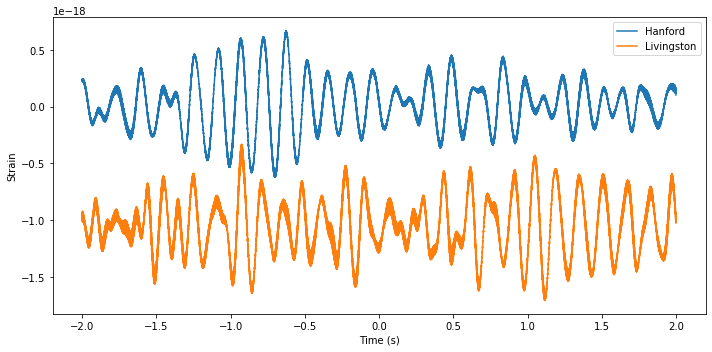

In [5]:
# Plotting the data to have a look
%matplotlib inline
import matplotlib.pyplot as plt

Time = np.arange(-2,2,1/4096)

plt.figure(figsize=(10,5))
plt.plot(Time, hanford_data, label="Hanford")
plt.plot(Time, livingston_data, label="Livingston")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.legend()
plt.tight_layout()
plt.show()

We have our waveform in the time domain, but we're looking for the waveform in the frequency domain. As you can see, the waveform is not periodic in our chunk of data, so we need to put the data through a window to relax the values on the boundardies. We can do this using a Tukey window. Once we've done that, we can FFT the data to get it into the frequency domain. We also see a DC offset in the Livingston that we need to get rid of.

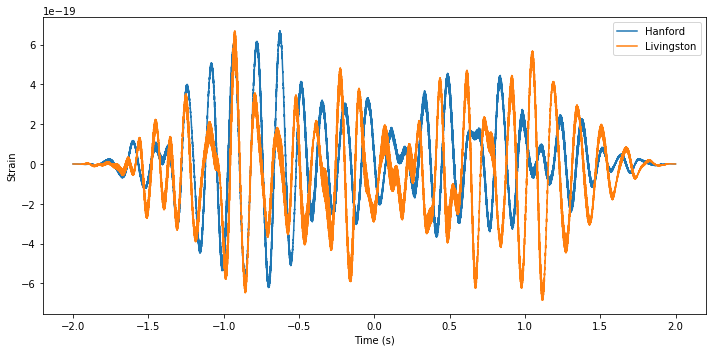

In [6]:
from scipy import signal
from scipy.fftpack import fft, ifft

# Creating Tukey window
window = signal.tukey(len(hanford_data), alpha=0.5)

# Applying window
hanford_data_Tukey = window*hanford_data
livingston_data_Tukey = window*(livingston_data + 1e-18)

plt.figure(figsize=(10,5))
plt.plot(Time,hanford_data_Tukey, label="Hanford")
plt.plot(Time,livingston_data_Tukey, label="Livingston")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.legend()
plt.tight_layout()
plt.show()

Nt = len(hanford_data_Tukey)

# Finding the frequency spacing associated with out time array
freq = np.fft.rfftfreq(Nt, 1/sample_rate)

# Fourier transform normalization
norm = 1./np.sqrt(sample_rate/2)

# Take the fourier transform of the data
hanford_data_Tukey_fft = np.fft.rfft(hanford_data_Tukey)*norm
livingston_data_Tukey_fft = np.fft.rfft(livingston_data_Tukey)*norm


## Getting the noise power spectral density

The next step is to get $S_{n}(f)$. The code below was written by LIGO and can be found [here](https://colab.research.google.com/github/losc-tutorial/Data_Guide/blob/master/Guide_Notebook.ipynb#scrollTo=92HQjQOddwpi). To calculate $S_{n}(f)$ from the data we have to calculate the Fourier transform of the data, at least that's one way to do it, but that results in a messy function that won't be of much use. Instead, we can use the Welch method of calculating $S_{n}(f)$. This method involves calculating the Fourier transforms of overlapping windowed chunks of the data and averaging them together. This returns a smooth $S_{n}(f)$ that can be interpolated and is something we can use in finding the power spectral density of the signal.

In [7]:

# Standard python numerical analysis imports:
import scipy
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt

# plotting items
%matplotlib inline
import matplotlib
import matplotlib.mlab as mlab

# -- Set some parameters that control how plots are displayed
plt.rcParams['figure.figsize'] = [5, 3]
plt.rcParams['lines.linewidth'] = .75

# LIGO-specific readligo.py 
# Download from https://www.gw-openscience.org/static/sample_code/readligo.py


# these 4096 second files are useful for computing more accurate psds
large_data_filenames = {'GW150914': 'GWOSC_4KHZ_R1-1126257415-4096.hdf5'}
#large_data_filenames = {'GW150914': 'LOSC_4_V2-1126257414-4096.hdf5'}
fn_H1 = 'H-H1_' + large_data_filenames['GW150914']
fn_L1 = 'L-L1_' + large_data_filenames['GW150914']

# his is the approximate event time which is used in the papers
time_center = 1126259462

# get sample rate from the H1 data file
with h5py.File(fn_H1, 'r') as hdf_file:
    dt = hdf_file['strain/Strain'].attrs['Xspacing']
fs = int(1.0/dt)
print("Using sample rate of {0} Hz found in file: {1}".format(fs, fn_H1))


def get_full_psds(eventnames, large_data_filenames,
                  make_plots=False, plot_others=False):
    """Obtains full 1024 second psds for all the events specified. Uses the Welch
    average technique, along with other less accurate techniques if
    specified. Can also plot the psd obtained.
    
    Args: 
        eventnames (list): list of events to get psds for
        large_datafilenames (dict): dictionary whose keys are the eventnames 
            and whose values are the filenames of the large amounts of strain
            data used, without the added 'H-<det>_'
        make_plots (bool, optional): if set to True, plot psd data
        plot_others (bool, optional): if set to True, also obtain psd data 
            without averaging as well as with no window
    
    Returns:
        dict: A dictionary containing psds for each detector for each event 
            specified in eventnames.
    """

    large_data_psds = {}
    for eventname in eventnames:
        large_data_psds[eventname] = {'H1': [], 'L1': []}

        # get filename
        fn_H1 = 'H-H1_' + large_data_filenames[eventname]
        fn_L1 = 'L-L1_' + large_data_filenames[eventname]

        # get strain data
        strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
        strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')

        # both H1 and L1 will have the same time vector, so:
        time = time_H1

        indxt_around = np.where((time >= time_center - 512) & (
            time < time_center + 512))

        # number of sample for the fast fourier transform:
        NFFT = 4 * fs           # Use 4 seconds of data for each fourier transform
        NOVL = 1 * NFFT / 2     # The number of points of overlap between segments used in Welch averaging
        psd_window = scipy.signal.tukey(NFFT, alpha=1./4)

        Pxx_H1, freqs = mlab.psd(strain_H1[indxt_around], Fs=fs, NFFT=NFFT,
                                 window=psd_window, noverlap=NOVL)
        Pxx_L1, freqs= mlab.psd(strain_L1[indxt_around], Fs=fs, NFFT=NFFT, 
                                window=psd_window, noverlap=NOVL)
        

        if (plot_others):
            # smaller window if we're not doing Welch's method
            short_indxt_away = np.where((time >= time_center - 2) & (
                time < time_center + 2))
            # psd using a tukey window but no welch averaging
            tukey_Pxx_H1, tukey_freqs = mlab.psd(
                strain_H1[short_indxt_away], Fs=fs, NFFT=NFFT, window=psd_window)
            # psd with no window, no averaging
            nowin_Pxx_H1, nowin_freqs = mlab.psd(
                strain_H1[short_indxt_away], Fs=fs, NFFT=NFFT, 
                window=mlab.window_none)

        # We will use interpolations of the PSDs computed above for whitening:
        psd_H1 = interp1d(freqs, Pxx_H1)
        psd_L1 = interp1d(freqs, Pxx_L1)

        large_data_psds[eventname]['H1'] = psd_H1
        large_data_psds[eventname]['L1'] = psd_L1

        if make_plots:
            plt.figure(figsize=(8, 5))
            # scale x and y axes
            plt.xscale('log', basex=2)
            plt.yscale('log', basey=10)

            # plot nowindow, tukey, welch together 
            plt.plot(nowin_freqs, nowin_Pxx_H1,'purple',label= 'No Window',
                     alpha=.8, linewidth=.5)
            plt.plot(tukey_freqs, tukey_Pxx_H1 ,'green',label='Tukey Window',
                     alpha=.8, linewidth=.5)
            plt.plot(freqs, Pxx_H1,'black',label='Welch Average', alpha=.8,
                     linewidth=.5)

            # plot 1/f^2
            # give it the right starting scale to fit with the rest of the plots
            # don't include zero frequency
            inverse_square = np.array(list(map(lambda f: 1 / (f**2), 
                                    nowin_freqs[1:])))
            # inverse starts at 1 to take out 1/0
            scale_index = 500 # chosen by eye to fit the plot
            scale = nowin_Pxx_H1[scale_index]  / inverse_square[scale_index]
            plt.plot(nowin_freqs[1:], inverse_square * scale,'red',
                     label= r'$1 / f^2$', alpha=.8, linewidth=1)

            plt.axis([20, 512, 1e-48, 1e-41])
            plt.ylabel('Sn(t)')
            plt.xlabel('Freq (Hz)')
            plt.legend(loc='upper center')
            plt.title('LIGO PSD data near ' + eventname + ' at H1')
            plt.show()

    return large_data_psds

Using sample rate of 4096 Hz found in file: H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5


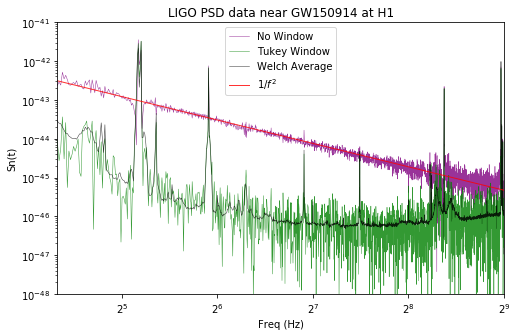

In [8]:
eventnames = ['GW150914']
large_data_psds = get_full_psds(eventnames, large_data_filenames,
                                make_plots=True, plot_others=True)

In [9]:
# Used all the data we need, so no use keeping it on your hard drive
os.remove(HANDFORD_PATH_hdf5)
os.remove(LIVINGSTON_PATH_hdf5)

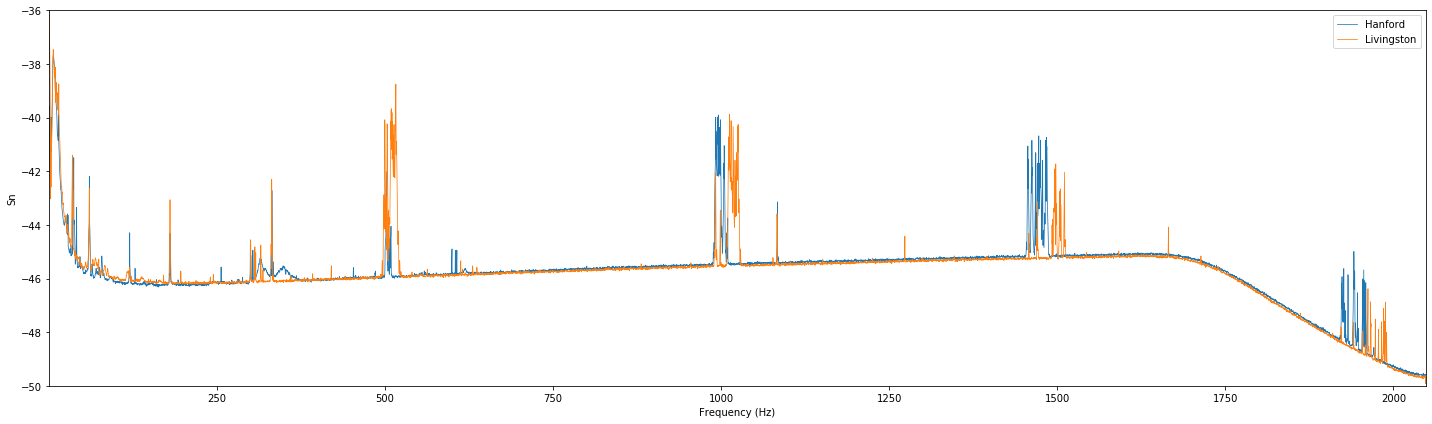

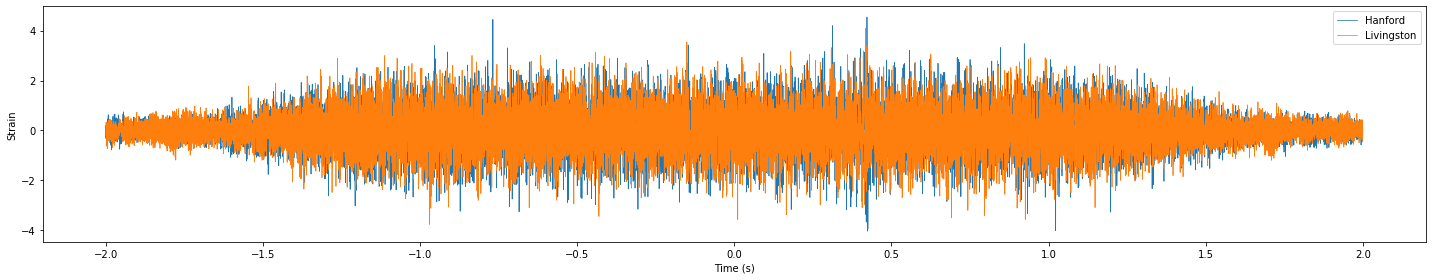

In [10]:
Sn_hanford = list(map(large_data_psds['GW150914']['H1'], np.abs(freq)))
Sn_livingston = list(map(large_data_psds['GW150914']['L1'], np.abs(freq)))

# Checking to see if my results match the LIGO results for the whitened waveform
A = hanford_data_Tukey_fft/np.sqrt(Sn_hanford)
B = livingston_data_Tukey_fft/np.sqrt(Sn_livingston)

hanford_data_Tukey_fft_ifft = np.fft.irfft(A, n=Nt)
livingston_data_Tukey_fft_ifft = np.fft.irfft(B, n=Nt)

Sn_hanford_t = np.fft.irfft(Sn_hanford, n=Nt)
Sn_livingston_t = np.fft.irfft(Sn_livingston, n=Nt)

plt.figure(figsize=(20,6))
plt.plot(freq, np.log10(Sn_hanford), label="Hanford")
plt.plot(freq, np.log10(Sn_livingston), label="Livingston")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Sn")
plt.legend()
plt.axis([freq[1], freq[-1], -50, -36])
plt.tight_layout()
plt.show()


plt.figure(figsize=(20,4))
plt.plot(Time,hanford_data_Tukey_fft_ifft, label="Hanford")
plt.plot(Time,livingston_data_Tukey_fft_ifft, label="Livingston")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.legend()
plt.tight_layout()
plt.show()

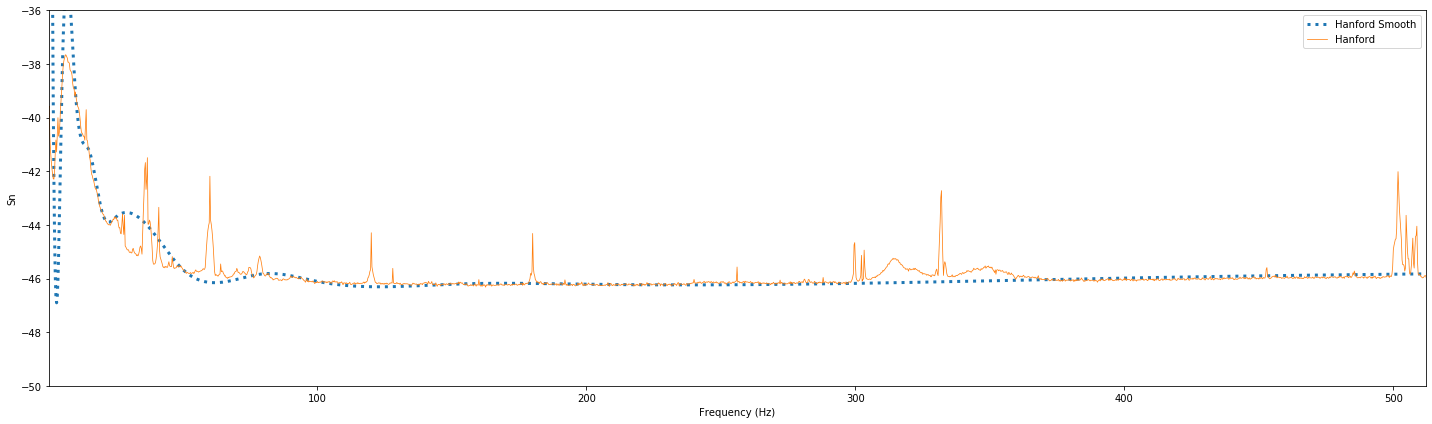

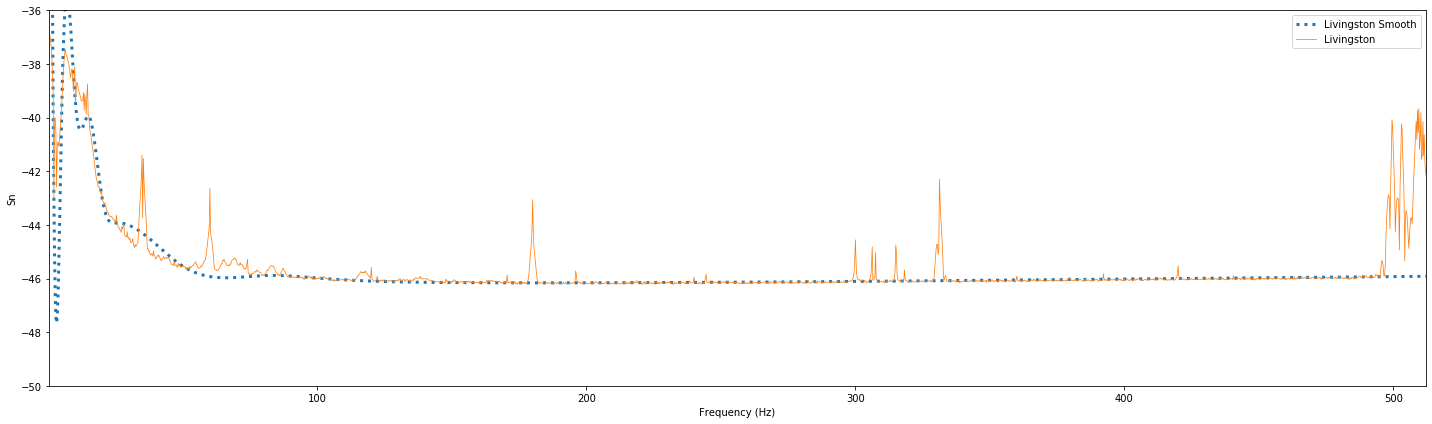

In [11]:
from scipy import interpolate

# The noise power spectral density is great, but I'd like a smoother version of it
# Here I interpolate it using points that looked good by eye
freq_interp = np.array([freq[1],2,5,10,15,20,25,50,80,100,150,200,400,750,1200,1550,1600,freq[-1]])
Sn_interp_values_H = list(map(large_data_psds['GW150914']['H1'], np.abs(freq_interp)))
Sn_interp_values_L = list(map(large_data_psds['GW150914']['L1'], np.abs(freq_interp)))

# To suppress higher frequencies that would oterwise dominate anything we would inverse FFT,
# I set the first value in the interpolation to infinity (10^36 times larger is a good enough approximation)
Sn_interp_values_H[0] = 1.0
Sn_interp_values_L[0] = 1.0

Sn_interp_H = interpolate.splrep(freq_interp, np.log10(Sn_interp_values_H), s=0)
Sn_interp_L = interpolate.splrep(freq_interp, np.log10(Sn_interp_values_L), s=0)

Sn_smooth_H = interpolate.splev(freq, Sn_interp_H, der=0)
Sn_smooth_L = interpolate.splev(freq, Sn_interp_L, der=0)

Sn_smooth_H = 10**(Sn_smooth_H)
Sn_smooth_L = 10**(Sn_smooth_L)

plt.figure(figsize=(20,6))
plt.plot(freq, np.log10(Sn_smooth_H), label="Hanford Smooth", linewidth = 3, linestyle=':')
plt.plot(freq, np.log10(Sn_hanford), label="Hanford")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Sn")
plt.legend()
plt.axis([freq[1], 512, -50, -36])
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,6))
plt.plot(freq, np.log10(Sn_smooth_L), label="Livingston Smooth", linewidth = 3, linestyle=':')
plt.plot(freq, np.log10(Sn_livingston), label="Livingston")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Sn")
plt.legend()
plt.axis([freq[1], 512, -50, -36])
plt.tight_layout()
plt.show()


## The SNR Time Series

Looking at the expression for $\rho(t, M_1, M_2)$ and at the expression for $z(t, M_1, M_2)$, we see we need
\begin{equation}
\rho(t, M_1, M_2) = \lvert z(t, M_1, M_2) \lvert = \left \lvert 4 \int^{\infty}_{0} \frac{\widetilde{d}(f) A(f, M_1, M_2) e^{-i \Psi(f, M_1, M_2)}}{S_{n}(f)} df \right \lvert .
\end{equation}

Here, d are the data, A and $\Psi$ are the amplitude and phase of the normalized template waveform. Since we have all the tools, we just need to put the pieces together. I first define a set of functions for the amplitude, phase, normalized waveform, inner product and the SNR time series.

In [12]:
# We want component masses, but the PhenomA functions take total mass and symmetric mass ratio
def phase(m1, m2, freq, t=0.0, phi=0.0):
    M = (m1 + m2)*TSUN
    eta = m1*m2/(m1 + m2)**2

    Phase = Psieff(freq, M, eta, t, phi)
    return Phase

def amp(m1, m2, freq, Dl):
    M = (m1 + m2)*TSUN 
    eta = m1*m2/(m1 + m2)**2

    Amp = Aeff(freq, M, eta, Dl)

    return Amp

# Need to normalize the waveform template to calculate the SNR time series
def waveform_norm(m1, m2, freq, Dl, Sn, df, t=0.0, phi=0.0, Factor=True):

    Phase = phase(m1, m2, freq, t, phi)
    Amp = amp(m1, m2, freq, Dl)

    Waveform = Amp*np.exp(1j*Phase)

    Waveform[0] = Waveform[1]

    if Factor is True: factor = (4.0*Waveform*Waveform.conj()/Sn).sum()*df
    if Factor is False: factor = 1.0
    Waveform = Waveform/np.sqrt(factor)

    return Waveform

def inner_product(waveform1, waveform2, Sn, df):
    value = 2.0*((waveform1*waveform2.conj() + waveform1.conj()*waveform2)/Sn).sum()*df
    return value

def SNR_func(waveform1, waveform2, Sn, norm, Nt):
    integrand = 4.0*waveform1.conj()*waveform2/Sn
    SitoNo = np.fft.ifft(integrand, n=Nt)/norm
    return SitoNo

mparsec = 3.086*10**22


In [13]:
# I first calculate the normalized waveforms using the Hanford and Livingston noise spectra
wave_temp_hanford = waveform_norm(39.0, 32.0, freq, 100*mparsec, Sn_hanford, 0.25)
wave_temp_livingston = waveform_norm(39.0, 32.0, freq, 100*mparsec, Sn_livingston, 0.25)

# I calculate the SNR time series as well as the time domain template waveform and the phase difference
SNR_hanford = SNR_func(wave_temp_hanford, hanford_data_Tukey_fft, Sn_hanford, norm, Nt)
wave_temp_hanford_t = np.fft.irfft(wave_temp_hanford/np.sqrt(Sn_hanford), n=Nt)/norm
phase_H = np.angle(hanford_data_Tukey_fft)
SNR_hanford = np.abs(SNR_hanford)

SNR_livingston = SNR_func(wave_temp_livingston, livingston_data_Tukey_fft, Sn_livingston, norm, Nt)
wave_temp_livingston_t = np.fft.irfft(wave_temp_livingston/np.sqrt(Sn_livingston), n=Nt)/norm
phase_L = np.angle(livingston_data_Tukey_fft)
SNR_livingston = np.abs(SNR_livingston)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in power
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in multiply
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in reciprocal
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in power


Below is the SNR time series. We see a large spike at around time -0.2 seconds. The value represents the time difference between the template and the data. To maximize over the coalescence time, we take this time difference to be the coalescence time. We also want to maximize over the phase, which is given via the the calculation above.

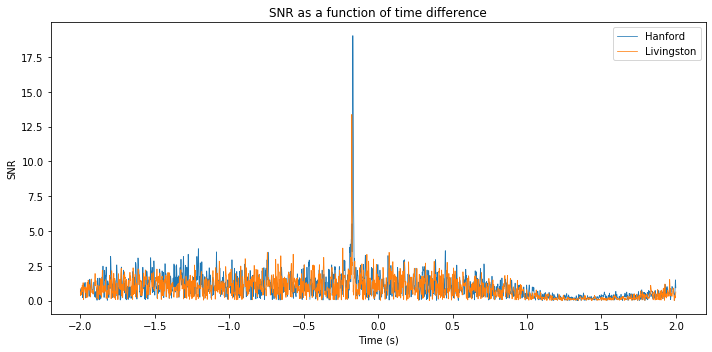

In [14]:
plt.figure(figsize=(10,5))
plt.plot(Time,SNR_hanford, label="Hanford")
plt.plot(Time,SNR_livingston, label="Livingston")
plt.title('SNR as a function of time difference')
plt.xlabel("Time (s)")
plt.ylabel("SNR")
plt.legend()
plt.tight_layout()
plt.show()

We want to determine the time differences and SNR at that time exactly, which is done below. We see the values for the SNR match well with those in the assignment and we see the time difference between the detectors is 7 ms.

In [15]:
SNR_H_max = np.amax(SNR_hanford)
SNR_L_max = np.amax(SNR_livingston)
max_time_H_ind = np.argmax(SNR_hanford)
max_time_L_ind = np.argmax(SNR_livingston)
max_time_H = Time[max_time_H_ind]
max_time_L = Time[max_time_L_ind]
phase_offset_H = phase_H[max_time_H_ind]
phase_offset_L = phase_L[max_time_L_ind]

print('The phase offset Hanford: ', phase_offset_H)
print('The phase offset Livingston: ', phase_offset_L)

print('The max SNR for Hanford: ', SNR_H_max)
print('The max SNR for Livingston: ', SNR_L_max)
print('The Hanford time: ', max_time_H)
print('The Livingston time: ', max_time_L)
print('The time difference: ', max_time_L-max_time_H)

The phase offset Hanford:  0.7707202357204155
The phase offset Livingston:  1.6727999334100123
The max SNR for Hanford:  19.034789774825445
The max SNR for Livingston:  13.372102434022203
The Hanford time:  -0.169677734375
The Livingston time:  -0.1767578125
The time difference:  -0.007080078125


Below are the time domain whitened template waveforms as checks to see if our waveform looks as it should.

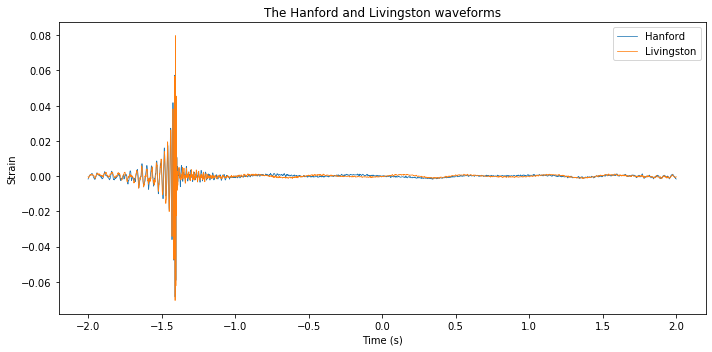

In [16]:
plt.figure(figsize=(10,5))
plt.plot(Time,np.real(wave_temp_hanford_t), label="Hanford")
plt.plot(Time,np.real(wave_temp_livingston_t), label="Livingston")
plt.title('The Hanford and Livingston waveforms')
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.legend()
plt.tight_layout()
plt.show()

## Maximum SNR Peak

I calculated a heat map of the quadrature combined maximum SNR in the detectors with masses between 5 and 100 solar masses using 1 solar mass spacing. We see there is a banana shaped region of similar maximum SNR which relates to similar total mass as the true binary. The max SNR found was 23.39 which corresponds to masses 43 and 28 solar mass black holes. 

In [17]:
import seaborn as sns
SNRs = np.zeros((100,100))
masses1 = np.zeros(100)
masses2 = np.zeros(100)

j=1
for i in range(0,100):
    for j in range(0,100): 
        M1 = (i+1)*1.0
        M2 = (j+1)*1.0
        
        # Generating template waveforms 
        wave_temp_H = waveform_norm(M1, M2, freq, 100*mparsec, Sn_hanford, 0.25)
        wave_temp_L = waveform_norm(M1, M2, freq, 100*mparsec, Sn_livingston, 0.25)

        # Using SNR function to determine the SNR time series
        SNR_H = SNR_func(wave_temp_H, hanford_data_Tukey_fft, Sn_hanford, norm, Nt)
        SNR_L = SNR_func(wave_temp_L, livingston_data_Tukey_fft, Sn_livingston, norm, Nt)

        SNR_H = np.abs(SNR_H)
        SNR_L = np.abs(SNR_L)

        # Finding the maximum value in the time series
        SNR_H_Max = np.amax(SNR_H)
        SNR_L_Max = np.amax(SNR_L)

        masses1[i] = M1
        masses2[j] = M2
        SNRs[i][j] = np.sqrt(SNR_H_Max*SNR_H_Max + SNR_L_Max*SNR_L_Max)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in power
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in multiply
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in reciprocal
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in power


In [18]:
num = np.argmax(SNRs)
num = num/100
Num = (num - np.floor(num))*100
print('The mass 1 at max SNR:', int(Num+1))
print('The mass 2 at max SNR:', int(num+1))
print('The max SNR: ', SNRs[int(num)][int(Num)])
print('The difference between the max SNR at the peak and the true masses: ', SNRs[int(num)][int(Num)]-SNRs[31][38])

The mass 1 at max SNR: 43
The mass 2 at max SNR: 28
The max SNR:  23.39177930186711
The difference between the max SNR at the peak and the true masses:  0.12944181661464782


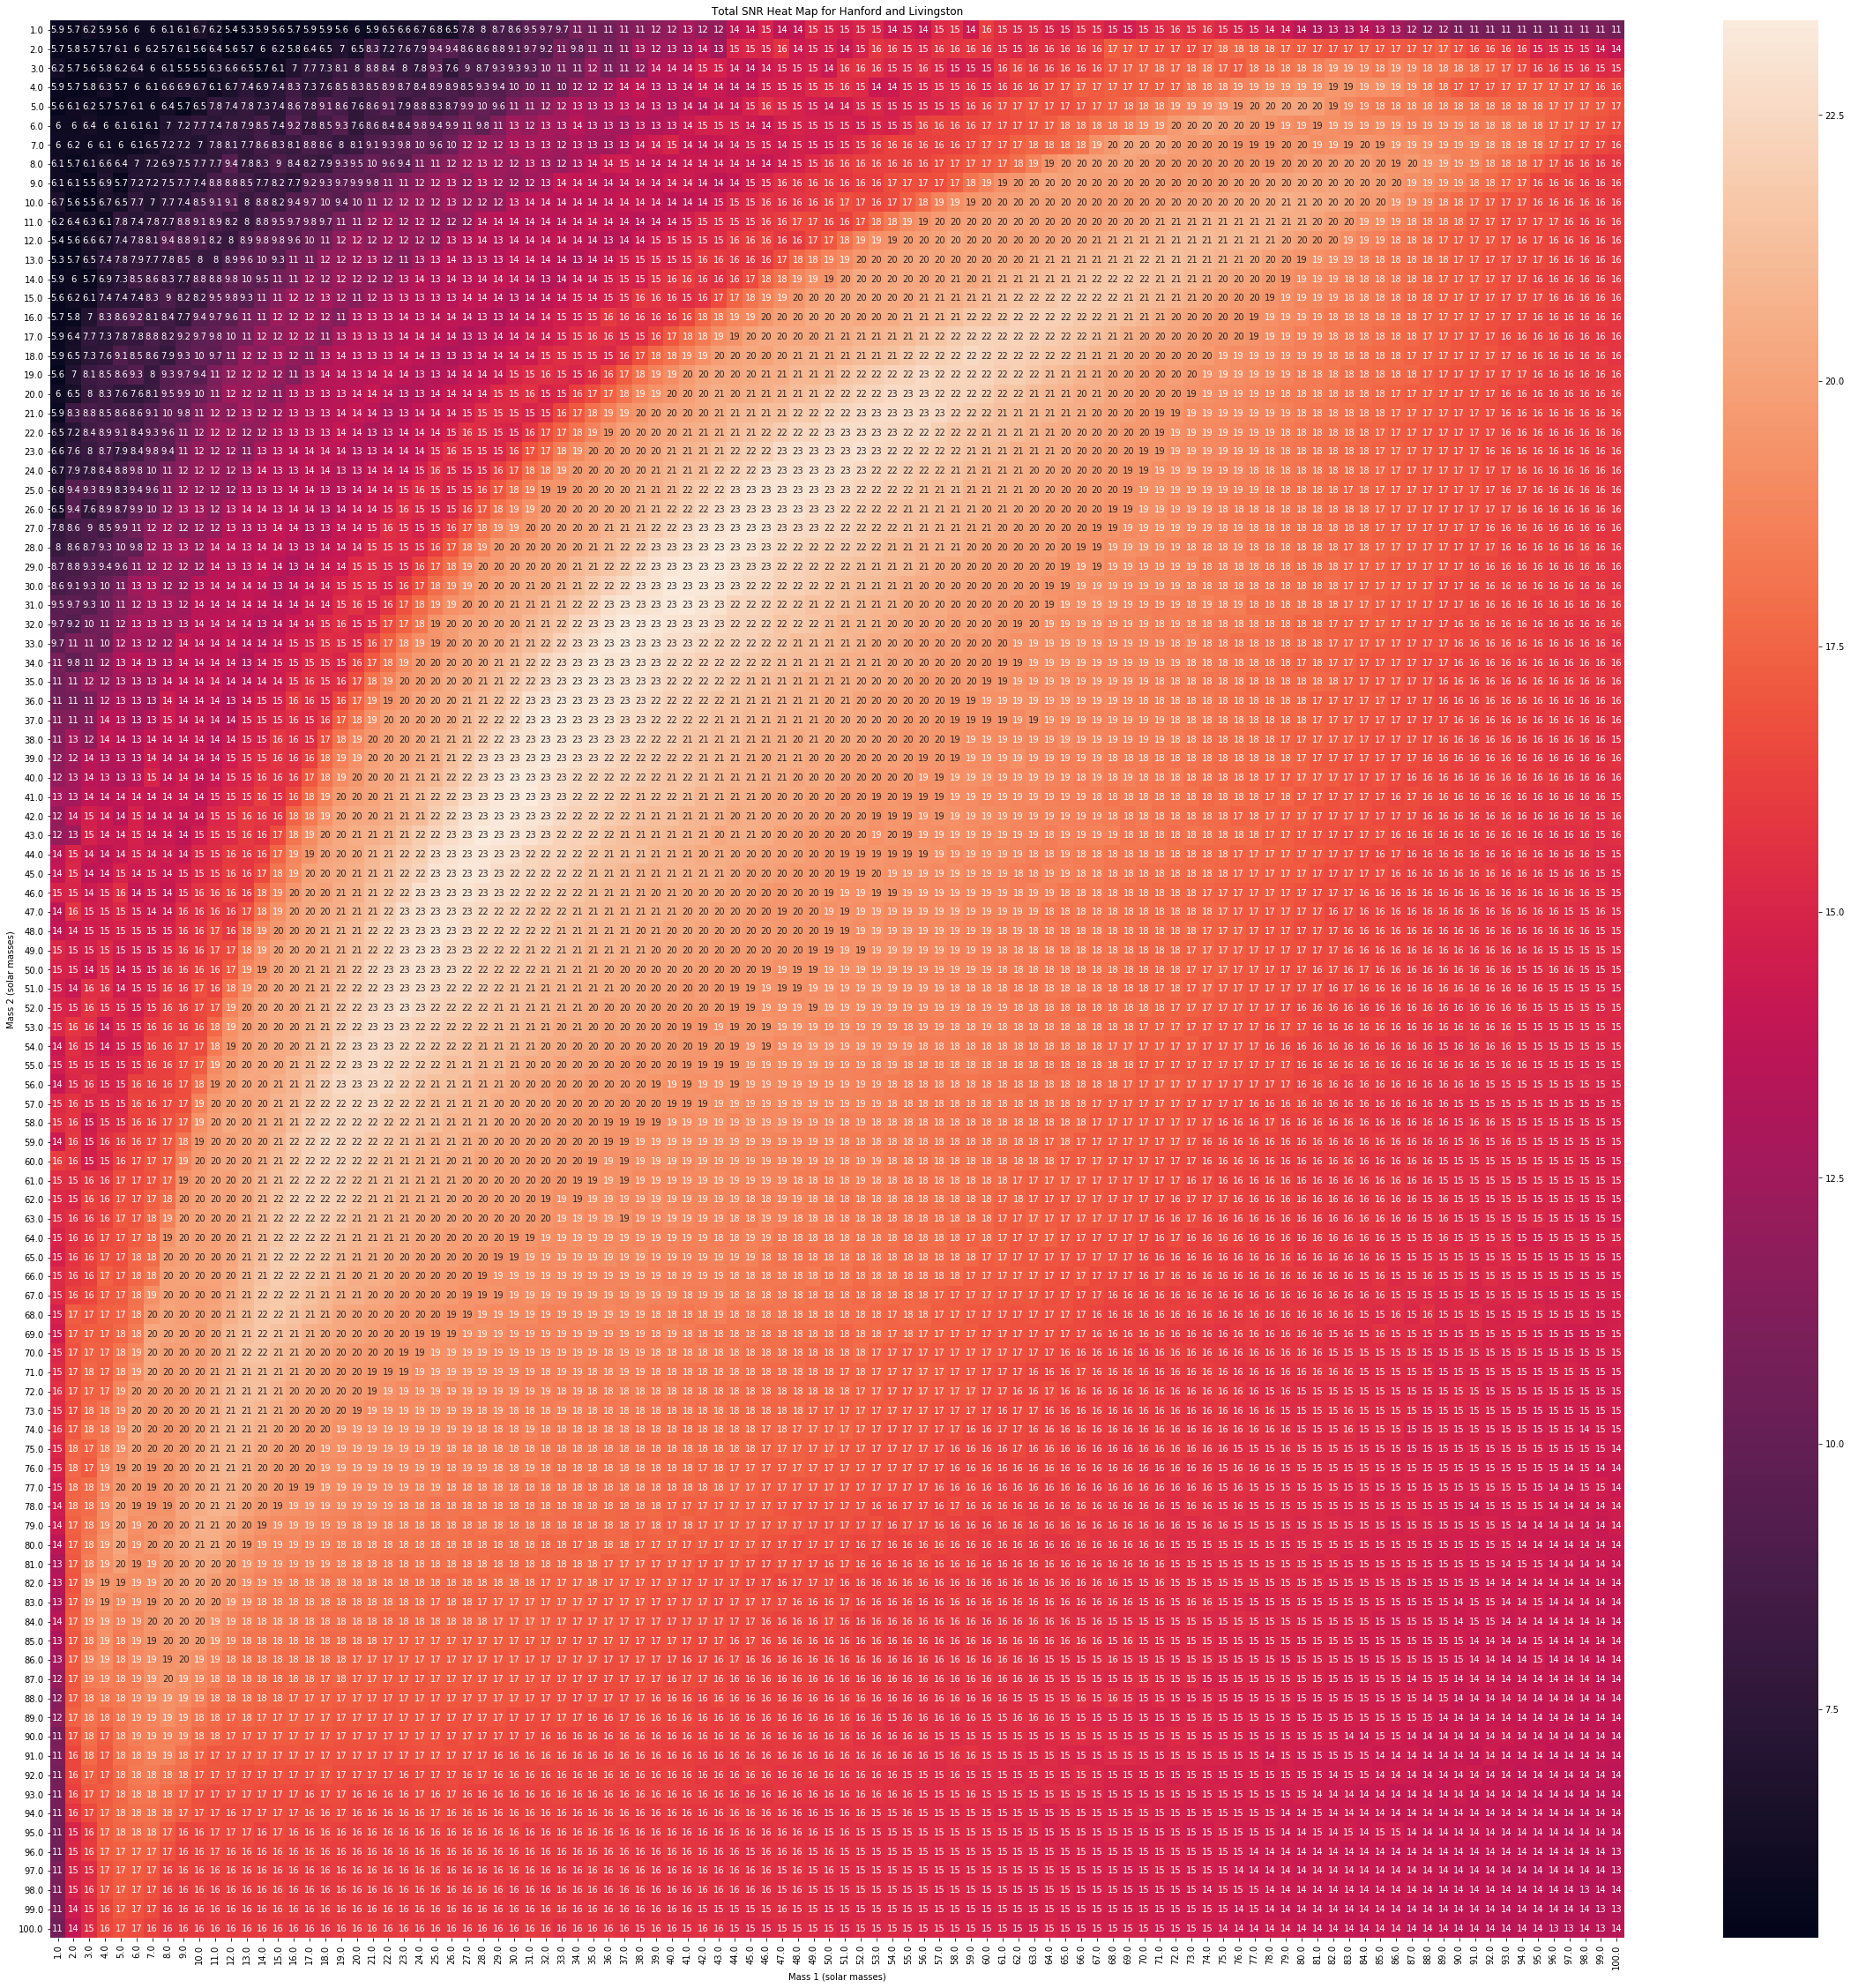

In [19]:
plt.figure(figsize=(40,40))
fig = sns.heatmap(SNRs, annot=True, xticklabels=masses1, yticklabels=masses2)
plt.title("Total SNR Heat Map for Hanford and Livingston")
plt.xlabel("Mass 1 (solar masses)")
plt.ylabel("Mass 2 (solar masses)")
plt.show()


# Grid Search

## Grid Spacing
I chose a grid spacing above for my SNR maximum calculation, but it was by choice. I want a grid spacing so that if I have a waveform with the true values, I'm guaranteed a match of about 0.97 or more. To find this spacing, I need to take a waveform template with the true values and a waveform with those values perturbed by the spacing and find the match between these waveforms. This translates into a Taylor expansion of the match by the grid spacing, which is given by
\begin{equation}
M(\boldsymbol{\lambda}, \boldsymbol{\lambda} + \Delta\boldsymbol{\lambda}) = 1 - \frac{1}{2} \left(\frac{(h_{,\mu}|h_{,\nu})}{(h|h)} - \frac{(h|h_{,\mu})(h|h_{,\nu})}{(h|h)^2} \right)\Delta \lambda^{\mu} \Delta \lambda^{\nu} + ... .
\end{equation}

Knowing that the waveforms themselves are not smooth, I used derivatives of the amplitudes and phases instead of derivatives of the waveform. This changes the inner products we have to take. There are two case, one for the term with both waveforms having their derivatives taken and one for the term with one waveform having its derivative taken. The inner products look like

\begin{equation}
(h_{,\mu}|h_{,\nu}) = 4 \int^{\infty}_{0} \frac{A_{,\mu}A_{,\nu} + A^{2}\Psi_{,\mu}\Psi_{,\nu}}{S_{n}(f)} df,
\end{equation}

\begin{equation}
(h_{}|h_{,\mu}) = 4 \int^{\infty}_{0} \frac{A A_{,\mu}}{S_{n}(f)} df .
\end{equation}

The results for the Hanford and Livingston are that the spacings should be about 0.0019 solar masses by 0.0019 solar masses. That is way too small. I'm not sure what is going wrong here, but this is the result I got. For the sake of time I did not try to make a heat map with that scaling, Python would take a very long time to run those for loops. Instead I assumed from the match plot given to us that the grid spacing should be about 5 solar masses by 5 solar masses.

In [20]:
# Calculates the amplitudes with perturbations, Calculates the normalizing factor, and Calculates the derivatives of the amplitudes using a central difference
def dev_amp(m1, m2, dm1, dm2, freq, Dl, Sn, df):
    Amp_pdm1 = amp(m1+dm1, m2, freq, Dl)
    Amp_mdm1 = amp(m1-dm1, m2, freq, Dl)
    Amp_pdm2 = amp(m1, m2+dm2, freq, Dl)
    Amp_mdm2 = amp(m1, m2-dm2, freq, Dl)
    
    Amp_pdm1[0] =Amp_pdm1[1]
    Amp_mdm1[0] =Amp_mdm1[1]
    Amp_pdm2[0] =Amp_pdm2[1]
    Amp_mdm2[0] =Amp_mdm2[1]

    factor_pdm1 = 4.0*(Amp_pdm1*Amp_pdm1/Sn).sum()*df
    factor_mdm1 = 4.0*(Amp_mdm1*Amp_mdm1/Sn).sum()*df
    factor_pdm2 = 4.0*(Amp_pdm2*Amp_pdm2/Sn).sum()*df
    factor_mdm2 = 4.0*(Amp_mdm2*Amp_mdm2/Sn).sum()*df

    Amp_pdm1 = Amp_pdm1/factor_pdm1
    Amp_mdm1 = Amp_mdm1/factor_mdm1
    Amp_pdm2 = Amp_pdm2/factor_pdm2
    Amp_mdm2 = Amp_mdm2/factor_mdm2

    dev_amp_m1 = (Amp_pdm1 - Amp_mdm1)/(2.0*dm1)
    dev_amp_m2 = (Amp_pdm2 - Amp_mdm2)/(2.0*dm2)

    return dev_amp_m1, dev_amp_m2

# Calculates the phases with pertrubations and calculates the derivatives of the phases using a central difference
def dev_phase(m1, m2, dm1, dm2, freq, t, phi):
    Phase_pdm1 = phase(m1+dm1, m2, freq, t, phi)
    Phase_mdm1 = phase(m1-dm1, m2, freq, t, phi)
    Phase_pdm2 = phase(m1, m2+dm2, freq, t, phi)
    Phase_mdm2 = phase(m1, m2-dm2, freq, t, phi)
    
    dev_Phase_m1 = (Phase_pdm1 - Phase_mdm1)/(2.0*dm1)
    dev_Phase_m2 = (Phase_pdm2 - Phase_mdm2)/(2.0*dm2)

    dev_Phase_m1[0] = dev_Phase_m1[1]
    dev_Phase_m2[0] = dev_Phase_m2[1]

    return dev_Phase_m1, dev_Phase_m1

# Calculates the inner products with the derivative waveforms
def doub_der_inner_prod(m1, m2, dm1, dm2, freq, Dl, t, phi, Sn_wave, Sn_match, df, Amp):
    dev_amp_m1, dev_amp_m2 = dev_amp(m1, m2, dm1, dm2, freq, Dl, Sn_wave, df)
    dev_Phase_m1, dev_Phase_m2 = dev_phase(m1, m2, dm1, dm2, freq, t, phi)

    inprod_m1_m1 = 4.0*((dev_amp_m1*dev_amp_m1 + Amp*Amp*dev_Phase_m1*dev_Phase_m1)/Sn_match).sum()*df
    inprod_m1_m2 = 4.0*((dev_amp_m1*dev_amp_m2 + Amp*Amp*dev_Phase_m1*dev_Phase_m2)/Sn_match).sum()*df
    inprod_m2_m2 = 4.0*((dev_amp_m2*dev_amp_m2 + Amp*Amp*dev_Phase_m2*dev_Phase_m2)/Sn_match).sum()*df

    return inprod_m1_m1, inprod_m1_m2, inprod_m2_m2

# Calculates the inner product with a waveform and a derivative of that waveform
def on_der_inner_prod(m1, m2, dm1, dm2, freq, Dl, t, phi, Sn_wave, Sn_match, df, Amp):
    dev_amp_m1, dev_amp_m2 = dev_amp(m1, m2, dm1, dm2, freq, Dl, Sn_wave, df)

    inprod_m1 = 4.0*((Amp*dev_amp_m1)/Sn_match).sum()*df
    inprod_m2 = 4.0*((Amp*dev_amp_m2)/Sn_match).sum()*df

    return inprod_m1, inprod_m2

# Calculates the match for a given spacing
def match_function(m1, m2, dm1, dm2, freq, Dl, Sn_wave, Sn_match, df, t, phi):

    waveform = waveform_norm(m1, m2, freq, Dl, Sn_wave, df, t, phi)
    Amp = amp(m1, m2, freq, Dl)
    Amp[0] = Amp[1]

    factor_amp = 4.0*(Amp*Amp/Sn_wave).sum()*df
    Amp = Amp/factor_amp

    h_m1_h_m1, h_m1_h_m2, h_m2_h_m2 = doub_der_inner_prod(m1, m2, dm1, dm2, freq, Dl, t, phi, Sn_wave, Sn_match, df, Amp)

    h_h_m1, h_h_m2 = on_der_inner_prod(m1, m2, dm1, dm2, freq, Dl, t, phi, Sn_wave, Sn_match, df, Amp)

    h_h = inner_product(Amp, Amp, Sn_match, df)
    h_h_2 = h_h * h_h

    g_m1_m1 = h_m1_h_m1/h_h - h_h_m1*h_h_m1/h_h_2
    g_m2_m2 = h_m2_h_m2/h_h - h_h_m2*h_h_m2/h_h_2
    g_m1_m2 = h_m1_h_m2/h_h - h_h_m1*h_h_m2/h_h_2

    match = 1 - 0.5*g_m1_m1*dm1*dm1 - 0.5*g_m2_m2*dm2*dm2 - g_m1_m2*dm1*dm2

    return np.real(match)

dm1_H = 0.0019
dm2_H = 0.0019
dm1_L = 0.0019
dm2_L = 0.0019

difference_match_H = match_function(39, 32, dm1_H, dm2_H, freq, 100*mparsec, Sn_hanford, Sn_smooth_H, 0.25, max_time_H, phase_offset_H)
difference_match_L = match_function(39, 32, dm1_L, dm2_L, freq, 100*mparsec, Sn_livingston, Sn_smooth_L, 0.25, max_time_L, phase_offset_L)
print('With grid spacing (',dm1_H,',', dm2_H,'), the match in the Hanford detector is ', difference_match_H)
print('With grid spacing (',dm1_L,',', dm2_L,'), the match in the Livingston detector is ', difference_match_L,'\n\n')



With grid spacing ( 0.0019 , 0.0019 ), the match in the Hanford detector is  0.9695909072447824
With grid spacing ( 0.0019 , 0.0019 ), the match in the Livingston detector is  0.9691592600182202 




C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in power
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in multiply
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in reciprocal
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in power


## Maximum SNR Values on the Grid

Similar to what was done before, I want to calculate the values for the maximum SNR for each set of masses on my grid.

In [21]:
SNRs_H = np.zeros((5,5))
SNRs_L = np.zeros((5,5))
masses1_new = np.zeros(5)
masses2_new = np.zeros(5)

# Calculating the maximum SNR values using the SNR time series for different mass templates
for i in range(0,5):
    j=4
    while j>=i:
        M1 = (i)*5.0 + 25
        M2 = (j)*5.0 + 25
        

        wave_temp_H = waveform_norm(M1, M2, freq, 100*mparsec, Sn_hanford, 0.25, max_time_H, phase_offset_H)
        wave_temp_L = waveform_norm(M1, M2, freq, 100*mparsec, Sn_livingston, 0.25, max_time_L, phase_offset_L)

        SNR_H = SNR_func(wave_temp_H, hanford_data_Tukey_fft, Sn_hanford, norm, Nt)
        SNR_L = SNR_func(wave_temp_L, livingston_data_Tukey_fft, Sn_livingston, norm, Nt)

        SNR_H = np.abs(SNR_H)
        SNR_L = np.abs(SNR_L)

        SNR_H_Max = np.amax(SNR_H)
        SNR_L_Max = np.amax(SNR_L)

        masses1_new[i] = M1
        masses2_new[j] = M2
        SNRs_H[i][j] = SNR_H_Max
        SNRs_L[i][j] = SNR_L_Max

        j -= 1 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in power
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in multiply
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in reciprocal
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in power


## SNR Heat Maps

We can see in the heat maps that we get our highest SNR in the block with values most similar to those of the true values.

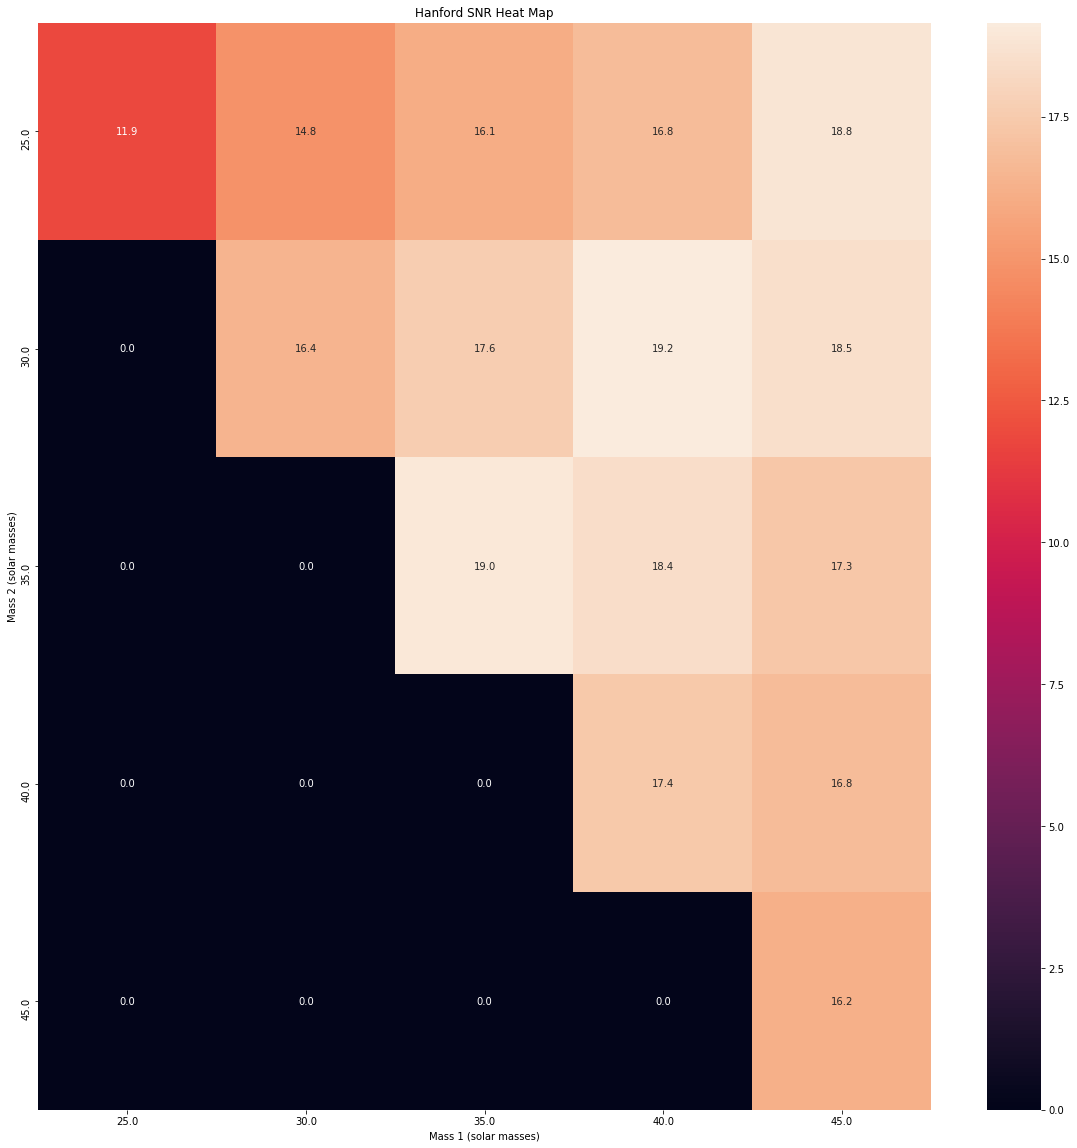

In [23]:
plt.figure(figsize=(20,20))
fig = sns.heatmap(SNRs_H, annot=True, fmt=".3", xticklabels=masses1_new, yticklabels=masses2_new)
plt.title("Hanford SNR Heat Map")
plt.xlabel("Mass 1 (solar masses)")
plt.ylabel("Mass 2 (solar masses)")
plt.show()

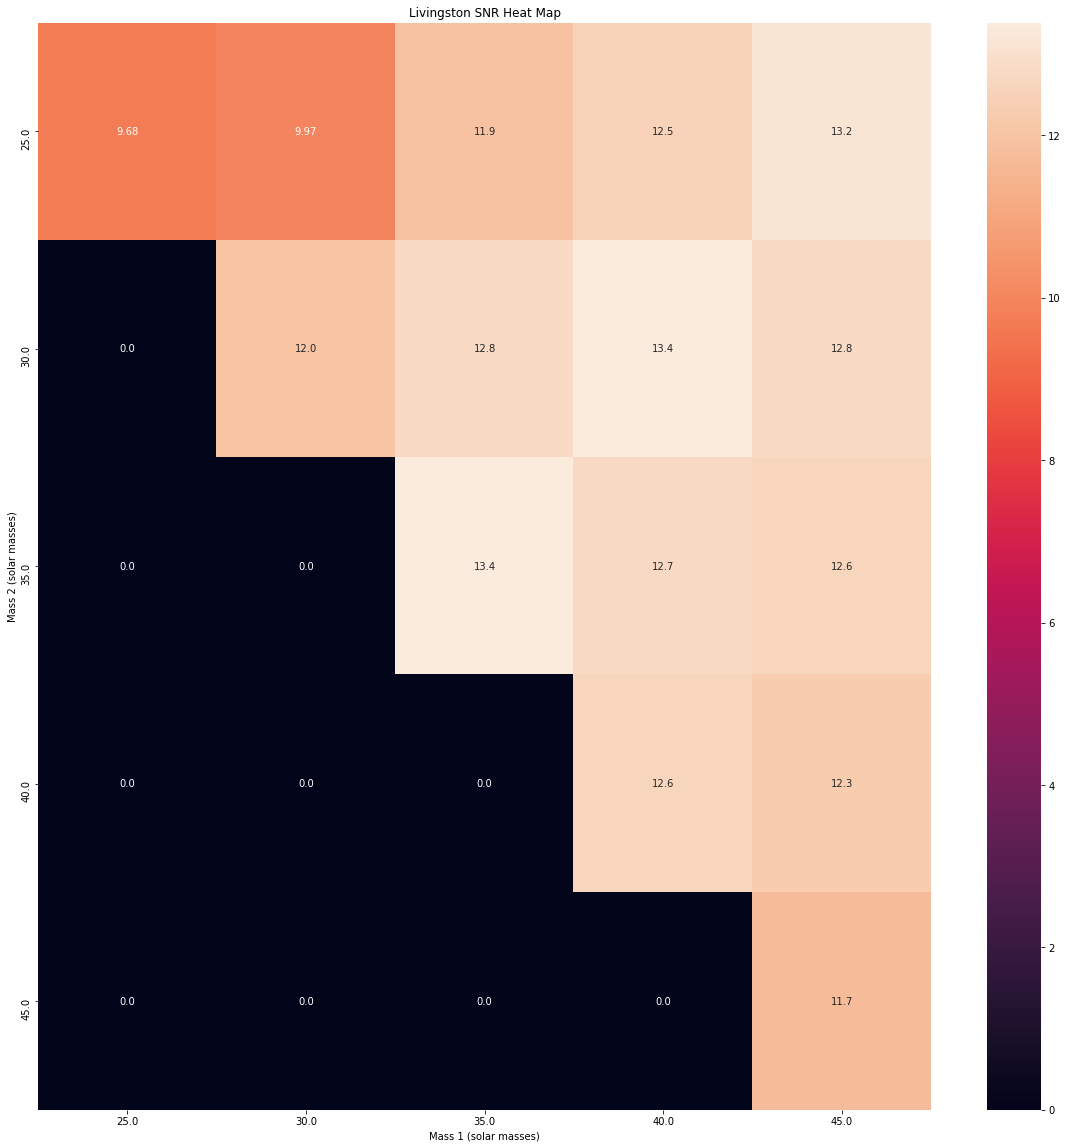

In [24]:
plt.figure(figsize=(20,20))
fig = sns.heatmap(SNRs_L, annot=True, fmt=".3", xticklabels=masses1_new, yticklabels=masses2_new)
plt.title("Livingston SNR Heat Map")
plt.xlabel("Mass 1 (solar masses)")
plt.ylabel("Mass 2 (solar masses)")
plt.show()

In [27]:
os.remove(HANFORD_TXT_txt)
os.remove(LIVINGSTON_TXT_txt)